<a href="https://colab.research.google.com/github/ppiont/tensor-flow-state/blob/master/data_impute.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
%cd '/gdrive/My Drive/tensor-flow-state/tensor-flow-state'

/gdrive/My Drive/tensor-flow-state/tensor-flow-state


In [0]:
sensor_list = ['RWS01_MONIBAS_0021hrl0403ra.csv', 'RWS01_MONIBAS_0021hrl0409ra.csv', 'RWS01_MONIBAS_0021hrl0414ra.csv', 'RWS01_MONIBAS_0021hrl0420ra.csv', 'RWS01_MONIBAS_0021hrl0426ra.csv']

In [0]:
import pandas as pd
import numpy as np

In [0]:
test = pd.read_csv('data/RWS01_MONIBAS_0021hrl0403ra.csv', index_col = 0, parse_dates = True)

In [0]:
import matplotlib.pyplot as plt

In [15]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4727520 entries, 2011-01-03 00:00:00 to 2019-12-29 23:59:00
Data columns (total 2 columns):
speed    float64
flow     float64
dtypes: float64(2)
memory usage: 108.2 MB


In [0]:
test2 = test.resample('M').agg({'speed': np.mean, 'flow': np.sum})

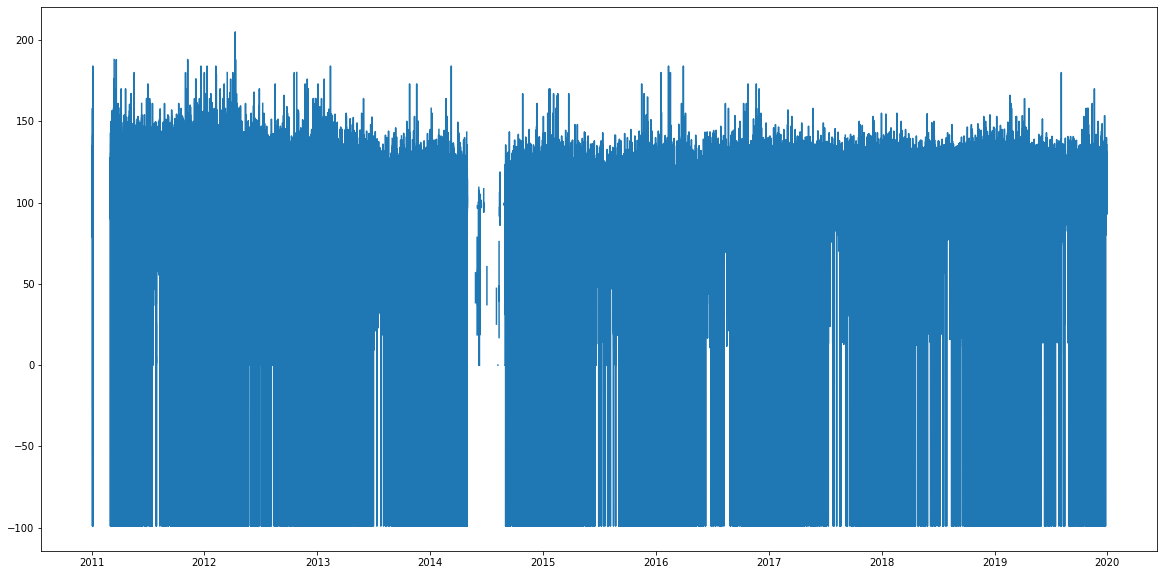

In [30]:
plt.figure(figsize=(20,10))
plt.plot(test2.speed)